<a href="https://colab.research.google.com/github/pihk94/DeepLearning/blob/master/Cycle_GAN_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning : Generative Adversarial Networksand Cycle-GAN
### May 2020 / ENSAE 
###### Melchior Prugniaud

The purpose of this notebook is to reproduce the Cycle Gan presented [here](https://junyanz.github.io/CycleGAN/) which is an Image to Image translation and transform the MNIST dataset to the USPS. 

Following the [proposed assignment](http://www.cs.toronto.edu/~rgrosse/courses/csc421_2019/assignments/assignment4.pdf), we will :

* Implement Deep Convolutionnal GAN

* Implement Cycle GAN

But first of all we need to import some packages and both dataset. I will use tensorflow and keras to do it.

In [1]:
import tensorflow as tf
from tensorflow.keras.backend import resize_images
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
import numpy as np
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.utils.vis_utils import plot_model
from tensorflow.keras import layers
import os
import time

Using TensorFlow backend.


# Prerequisite Datasets preprocessing

### Load MNIST Dataset
MNIST dataset consist of 70 000 digits of size 28x28.

In [0]:
train_mnist,test_mnist = mnist.load_data()
train_mnist[0].shape,train_mnist[1].shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,))

In [0]:
img_mnist,label_mnist = train_mnist[0],train_mnist[1]
imgs,labels = [],[]
j=0
while len(imgs)<=9:
  for i in range(len(img_mnist)):
    if not label_mnist[i] in labels and label_mnist[i] ==j:
      labels.append(label_mnist[i])
      imgs.append(img_mnist[i])
      j+=1

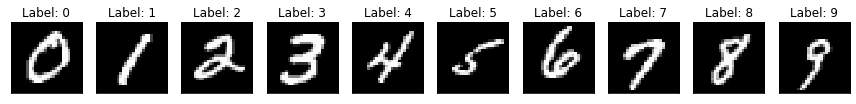

In [0]:
plt.figure(figsize =(12,12))
for i in range(1,11):
  plt.subplot(1,10,i)
  plt.imshow(imgs[i-1],cmap='gray',interpolation='none')
  plt.title("Label: {}".format(labels[i-1]))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()

Let's try to resize our image to 32 x 32 as asked in the input from the assignment.


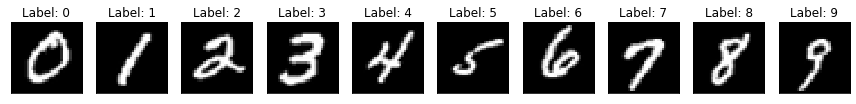

In [0]:
plt.figure(figsize =(12,12))
for i in range(1,11):
  plt.subplot(1,10,i)
  plt.imshow(cv2.resize(imgs[i-1], dsize=(32,32), interpolation=cv2.INTER_CUBIC),cmap='gray',interpolation='none')
  plt.title("Label: {}".format(labels[i-1]))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()

Looks like it's working good, we will apply it on a function to prepare datasets.
### Load USPS dataset

Let's now load the USPS dataset, unfortunately keras does not have the dataset, so we load it with torchvision.


In [0]:
from torchvision import datasets
train_usps = datasets.USPS(root='content/',download=True,train=True)
test_usps = datasets.USPS(root='content/',download=True,train=False)

In [0]:
train_usps[0]

(<PIL.Image.Image image mode=L size=16x16 at 0x7F025A020278>, 6)

In [0]:
data = train_usps
imgs,labels = [],[]
j=0
while len(imgs)<=9:
  for i in range(len(data)):
    if not data[i][1] in labels and data[i][1] ==j:
      labels.append(data[i][1])
      imgs.append(data[i][0])
      j+=1

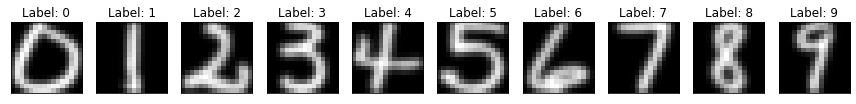

In [0]:
plt.figure(figsize =(12,12))
for i in range(1,11):
  plt.subplot(1,10,i)
  plt.imshow(imgs[i-1],cmap='gray',interpolation='none')
  plt.title("Label: {}".format(labels[i-1]))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()

Let's reshape again this 16x16 imgs to 32x32

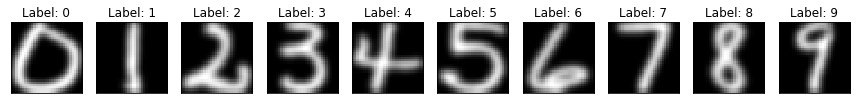

In [0]:
plt.figure(figsize =(12,12))
for i in range(1,11):
  plt.subplot(1,10,i)
  plt.imshow(imgs[i-1].resize((32,32)),cmap='gray',interpolation='none')
  plt.title("Label: {}".format(labels[i-1]))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()

## Prepare datasets loader

Here is two function , one for each dataset to load data in the good format for our networks.

In [0]:
def prepare_mnist_tensor(BATCH_SIZE):
  (train_img,_),(test_mnist,_) = mnist.load_data()
  train_img = train_img.reshape(train_img.shape[0],train_img.shape[1],train_img.shape[2],1)
  t = np.empty((train_img.shape[0],32,32))
  for i in range(train_img.shape[0]):
    t[i] = cv2.resize(train_img[i], dsize=(32,32), interpolation=cv2.INTER_CUBIC)
  t = t.reshape(train_img.shape[0],32,32,1)
  train_img = t.astype('float32')
  #normalize data
  train_img = (train_img -127.5)/127.5
  return tf.data.Dataset.from_tensor_slices(train_img).shuffle(train_img.shape[0]).batch(BATCH_SIZE)

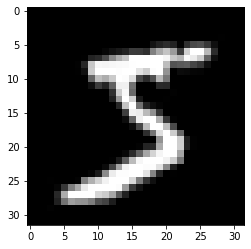

In [27]:
plt.imshow(t[0],cmap='gray',interpolation='none')

# Part 1: Deep Convolutional GAN (DCGAN)

In the first part, the assignment ask to implement the DCGAN.
We will follow this blueprint : 

* Create discriminator

* Create generator

* Create the training procedure


## Discriminator

We have to reproduce this architecture : 


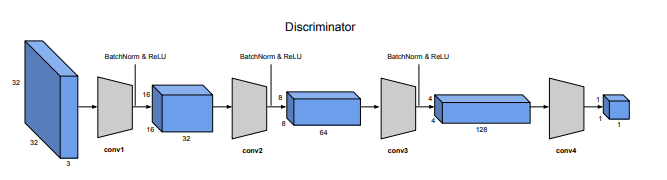

In [3]:
def dis_model(input_shape=(32,32,1)):
  init = RandomNormal(stddev=0.02) #as used in the article of CycleGan
  padding = 'same'
  kernels = (4,4)
  strides = (2,2)
  size = 64
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(32,(5,5),strides =strides,padding = padding,kernel_initializer=init,input_shape=input_shape))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.05))
  model.add(layers.Conv2D(64,(5,5),strides =strides,padding = padding,kernel_initializer=init,input_shape=input_shape))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.05))
  model.add(layers.Conv2D(128,(5,5),strides =strides,padding = padding,kernel_initializer=init,input_shape=input_shape))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU(alpha=0.05))
  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  return model
dis_model((32,32,1)).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         2

Taking our initial shape, we got the following model for our discriminator.

## Generator

Let's now try to make the generator model. The representation is : 

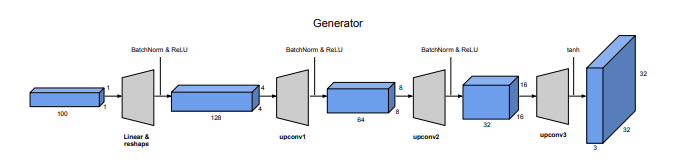

Since we have only 28x28 images, we delete one layer

In [4]:
def gen_model():
    init = RandomNormal(stddev=0.02) #as used in the article of CycleGan
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*64, use_bias=False, input_shape=(100,),kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((4, 4, 64)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False,kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False,kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False,kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False,kernel_initializer=init,activation='tanh'))
    model.summary()
    return model
gen_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              102400    
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024)              4096      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 128)         204800    
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4, 4, 128)        

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 4096)              409600    
_________________________________________________________________
batch_normalization_12 (Batc (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 4, 4, 128)         819200    
_________________________________________________________________
batch_normalization_13 (Batc (None, 4, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 4, 4, 128)        

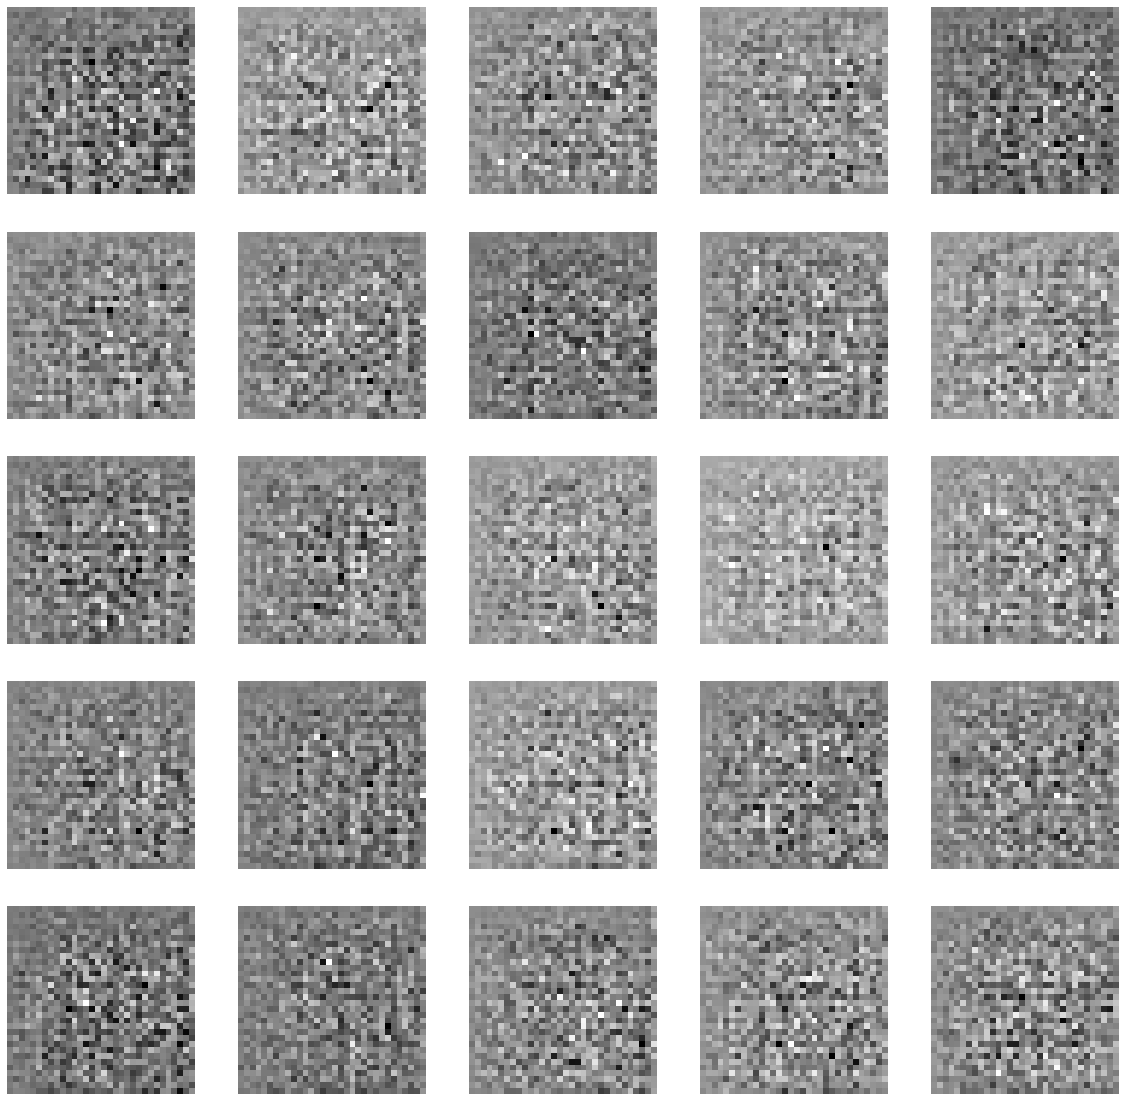

In [7]:
gen = gen_model()
noise = tf.random.normal([25, 100])
gen.training=False
X = gen(noise)
plt.figure(figsize=(20,20))
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(X[i, :, :, 0], cmap='gray_r')

We then use the loss of our model

Set the seed

Save results 

Define the training step

## Training Loop


Here is a representation of the untrained generator.

In [0]:
dataset = prepare_mnist_tensor(256)

In [5]:
discriminator = dis_model()
generator = gen_model()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              102400    
_________________________________________________________________
batch_normalization_10 (Batc (None, 1024)              4096      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 4, 4, 128)         204800    
_________________________________________________________________
batch_normalization_11 (Batc (None, 4, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 4, 4, 128)        

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 25
BATCH_SIZE = 256
seed = tf.random.normal([num_examples_to_generate, noise_dim])
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss,disc_loss
def train(dataset, epochs):
  from IPython import display
  global_loss_gen = []
  global_loss_disc = []
  for epoch in range(epochs):
    start = time.time()
    loss_gen = []
    loss_disc = []
    for image_batch in dataset:
      (g,d) = train_step(image_batch)
      loss_gen.append(g),loss_disc.append(d)
    global_loss_gen.append(np.mean(loss_gen)),global_loss_disc.append(np.mean(loss_disc))
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    print(f'Generator loss : {np.mean(loss_gen)}\nDiscriminator loss : {np.mean(loss_disc)}')
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    plt.figure(figsize=(12,12))
    plt.plot(range(len(global_loss_gen)),global_loss_gen,color='blue')
    plt.plot(range(len(global_loss_disc)),global_loss_disc,color='red')
    plt.show()
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  plt.figure(figsize=(12,12))
  plt.plot(range(len(global_loss_gen)),global_loss_gen,color='blue')
  plt.plot(range(len(global_loss_disc)),global_loss_disc,color='red')
  plt.savefig('final.png')
  plt.show()
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(16,16))
  for i in range(predictions.shape[0]):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.suptitle(f"Epoch : {epoch}", fontsize=14)
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [0]:
train(dataset, EPOCHS)

In [0]:
import imageio
import glob
anim_file = 'anim.gif'

with imageio.get_writer(anim_file, mode='I',duration='1') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

In [0]:
imageio.get_writer